## Imports

In [2]:
import lxml.etree
import healpy as hp
import numpy as np
import pandas as pd
import gcn
import astropy_healpix
import astropy.utils.data
from astropy.coordinates import SkyCoord,concatenate
import astropy.units as u
from ligo.skymap.postprocess import crossmatch
from ligo.skymap.io import read_sky_map
import ligo.skymap.plot
from contours import contour_plots,join_0_360,split_contours,integrated_probability,hpix_contours
from GLADE import GLADEV2coordinates,PS1coordinates
from skymapio import readskymap
import matplotlib.pyplot as plt
from collections import OrderedDict
from astrobase.coordutils import make_kdtree
from astrobase.coordutils import conesearch_kdtree
from matplotlib.patches import Circle
from fields import inside_circle, circ, intersect_2_or_3, split_between_3_overlap, split_between_2_overlap
import fsspec

## Loading the alert

In [3]:
# Load the alert

payload = open('S200129m-3-Initial.xml', 'rb').read()
root = lxml.etree.fromstring(payload)
params = {elem.attrib['name']:
              elem.attrib['value']
              for elem in root.iterfind('.//Param')}

In [4]:
print(params['skymap_fits'])

https://gracedb.ligo.org/api/superevents/S200129m/files/LALInference.fits.gz


## Read skymap and create x% contours

In [179]:
# get the ID and alert type
graceid=params['GraceID']
prelim=params['AlertType']+params['Pkt_Ser_Num']

# Read the HEALPix sky map and the FITS header.
skymap, prob, distmu, distsigma, distnorm, npix, nside, distest, diststd = readskymap(params['skymap_fits'])

# Get the integrated probability map
csm=integrated_probability(prob)

# Identify the x% contours
contours=hpix_contours(csm,levels=[0.8],nest=False)
levels=[0.8]
levelsper=[80]

## Load GLADE and PS1 sources

In [180]:
# Get all galaxies from GLADE
coordinates1,data=GLADEV2coordinates()
data['source']='GLADE'
# Get all extended sources from PS1 from Google Drive csv file

coordinates, data1= PS1coordinates('s3://gxgwtest/GW200129m_total1_Lana_S.csv')

data1['source']='PS1'
data1['raMean']=data1['RA']
data1['decMean']=data1['Dec']
# concatenate coordinates of GLADE and PS1 sources
coordinates=concatenate([coordinates1, coordinates])
index=[]
data = pd.concat([data,data1])


lengthofdata 3262881


## Crossmatch skymap with sources

In [183]:
# read sky map
url='https://gracedb.ligo.org/api/superevents/'+graceid+'/files/LALInference.multiorder.fits'
skymap=read_sky_map(url, moc=True)

# healpy crossmatch skymap with galaxies
result=crossmatch(skymap,coordinates)

#separate masked array into separate contours
split_dec, split_ra = split_contours(contours, levels[0],0)
split_ra2, split_dec2=join_0_360(split_ra, split_dec)

# just take galaxies within x%
results=data[result.searched_prob<0.991]
ra_incontour=results['RA'].values
dec_incontour=results['Dec'].values
for t in range(0,len(results)):
    index.append('200129_'+str(t))
results['our_id']=index
results=results[((results['RA']>315) | (results['RA']<311.5)) & ((results['Dec']<11.5) | (results['Dec']>24)) & (results['Dec']>0) & (results['RA']>307.5)  & (results['RA']<320.5) & ((results['Dec']<31)) ]
results.to_csv('200219_results.csv')

[3.20883768e-04 6.41716087e-04 9.62485699e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
contouridx []
skymap []


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Plot

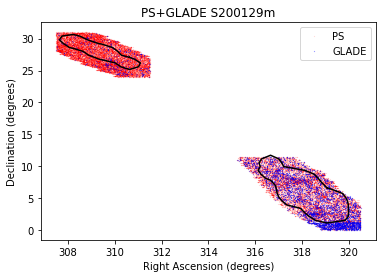

20861
17402
3812


In [206]:
# plot contours and galaxies
plt.figure(1)
plt.plot(results['RA'][results['source']=='PS1'],results['Dec'][results['source']=='PS1'],'r.', markersize=0.1, label='PS')
plt.plot(results['RA'][results['source']=='GLADE'],results['Dec'][results['source']=='GLADE'],'b.', markersize=0.3, label='GLADE')
for r in range(0,len(split_ra2)):
    plt.plot(split_ra2[r],split_dec2[r],'k-')

plt.ylabel('Declination (degrees)')
plt.xlabel('Right Ascension (degrees)')
plt.title('PS+GLADE S200129m')
plt.legend()
plt.savefig('200129m_80_PS_GLADE.pdf')
plt.show()